In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import time
import webbrowser
import folium
import googlemaps
import mysql.connector

/tmp/ipykernel_16142/495930524.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1. 생과일 vs 건조과일 수입 물량 비교

In [45]:
url = "https://www.bandtrass.or.kr/customs/total.do?command=CUS001View&viewCode=CUS00201"

driver = webdriver.Chrome(service=Service('../driver/chromedriver-linux64/chromedriver'))

driver.get(url)
time.sleep(1)

In [46]:
GOODS_DIV =driver.find_element(By.ID, 'GODS_DIV')
GOODS_DIV.click()
GOODS_TYPE = WebDriverWait(driver, timeout=10).until(EC.visibility_of_element_located((By.ID, "GODS_DIV_select"))) 
GOODS_TYPE.click()
three = GOODS_TYPE.find_elements(By.TAG_NAME, 'option')
three[1].click()

#### 웹 크롤링
##### 품목 검색하기 ~ 새로운 창 확인

In [17]:
def Search_Item():
    selector = "#POPUP1"
    elem = driver.find_element(By.CSS_SELECTOR, selector)
    elem.click()

    # Store the ID of the original window
    original_window = driver.current_window_handle
    print(f'Original window: {original_window}')
    print('=====================================')
    # Click the link which opens in a new window
    selector = "#POPUP1"
    elem = driver.find_element(By.CSS_SELECTOR, selector)
    elem.click()

    # Wait for the new window or tab
    WebDriverWait(driver, timeout=10).until(EC.number_of_windows_to_be(2))

    # Loop through until we find a new window handle
    for window_handle in driver.window_handles:
        if window_handle != original_window:
            driver.switch_to.window(window_handle)
            print('Switched!!')
            print(f'New window: {window_handle}')
            break

    return original_window

In [18]:
original_window = Search_Item()

Original window: 6C44BE26FBEB582C3A4A19DEF8B10A11
Switched!!
New window: 03F5BD770548BCFCA3B8B6B20424A21F


### 새로운 창 ~ 품목 코드 번호 조회 완료

#### 1. 건조사과

In [19]:
def New_Window(li, og):
    # 새로운 창
    vsc_initialized = driver.find_element(By.CSS_SELECTOR, "body")
    # HS CODE 2자리
    HS_CODE_2 = vsc_initialized.find_element(By.ID, 'tb_list1')

    # 품목명 선택
    item_category = WebDriverWait(HS_CODE_2, timeout=10).until(EC.visibility_of_element_located((By.LINK_TEXT, li[0])))
    item_category.click()

    # HS CODE 4자리
    HS_CODE_4 = WebDriverWait(vsc_initialized, timeout=10).until(EC.visibility_of_element_located((By.ID, "tb_list4")))
    code_num_1st = WebDriverWait(HS_CODE_4, timeout=10).until(EC.visibility_of_element_located((By.LINK_TEXT, li[1])))
    code_num_1st.click()

    # HS CODE 6자리
    HS_CODE_6 = WebDriverWait(vsc_initialized, timeout=10).until(EC.visibility_of_element_located((By.ID, "tb_list6")))
    code_num_2nd = WebDriverWait(HS_CODE_6, timeout=10).until(EC.visibility_of_element_located((By.LINK_TEXT, li[2])))
    code_num_2nd.click()

    # HS CODE 10자리
    HS_CODE_10 = WebDriverWait(vsc_initialized, timeout=10).until(EC.visibility_of_element_located((By.ID, "tb_list10")))
    item = WebDriverWait(HS_CODE_10, timeout=10).until(EC.visibility_of_element_located((By.LINK_TEXT, li[3])))
    item.click()

    # 선택한 HSCODE
    tbody_Select = WebDriverWait(vsc_initialized, timeout=10).until(EC.visibility_of_element_located((By.ID, "tbody_Select")))
    research_result = tbody_Select.text.split(' ')[-1]

    # 선택적용 버튼
    apply_bt = WebDriverWait(vsc_initialized, timeout=10).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "#wrap > div > div.tb_in_wrap > div > p:nth-child(2) > button")))
    apply_bt.click()

    # 원래 창 복귀
    driver.switch_to.window(og)
    print('Switched!!')
    
    # 확인
    item_code = WebDriverWait(driver, timeout=10).until(EC.visibility_of_element_located((By.ID, "FILTER1_CODE")))
    print(item_code.text)



In [20]:
li = ["과실·견과류", "0813", "081330", "사과"]
New_Window(li, original_window)

Switched!!
0813300000


#### 원하는 연도 선택

In [21]:
BASE_YEAR = driver.find_element(By.ID, 'BASE_YEAR')
BASE_YEAR.click()
YEARS = BASE_YEAR.find_elements(By.TAG_NAME, 'option')
#len(YEARS) 2024 ~ 2000

#### 2000 ~ 2024년 품목 무게 뽑기

In [22]:
def Extract_item_kg(YEARS):
    item_kg_list=[]
    
    for y in YEARS:
        y.click()
        do_research = WebDriverWait(driver, timeout=10).until(EC.visibility_of_element_located((By.CLASS_NAME, "btn.btn-ok.btn-lg"))) 
        do_research.click()
        item_info = WebDriverWait(driver, timeout=50).until(EC.visibility_of_element_located((By.ID, "1")))
        item_info = item_info.find_elements(By.TAG_NAME, 'td')
        item_kg = item_info[-1].text
        item_kg = item_kg.replace(',', '')
        item_kg_list.append(float(item_kg))

    #print(len(item_kg_list))

    return item_kg_list

In [92]:
dried_kg_list = Extract_item_kg(YEARS)
year_list = [y for y in range(2024,1999,-1)]

#### 2. 생사과

In [24]:
original_window = Search_Item()

Original window: 6C44BE26FBEB582C3A4A19DEF8B10A11
Switched!!
New window: C53873026F8FB2816224F274DCC5746E


In [25]:
li = ["과실·견과류", "0808", "080810", "사과"]
New_Window(li, original_window)

Switched!!
0808100000


In [26]:
BASE_YEAR = driver.find_element(By.ID, 'BASE_YEAR')
BASE_YEAR.click()
YEARS = BASE_YEAR.find_elements(By.TAG_NAME, 'option')

In [27]:
raw_kg_list = Extract_item_kg(YEARS)

#### DF 만들기

In [28]:
df_apple_raw_dried = pd.DataFrame({'date': year_list, 'raw(kg)': raw_kg_list, 'dried(kg)': dried_kg_list})

df_apple_raw_dried.drop([0], axis=0, inplace=True)
df_apple_raw_dried = df_apple_raw_dried.reset_index(drop=True)
df_apple_raw_dried

,date,raw(kg),dried(kg)
0,2023,0.0,8803.28
1,2022,0.0,2935.34
2,2021,12.9,6229.53
3,2020,13230.1,2422.92
4,2019,13230.0,2397.04
5,2018,0.0,2973.25
6,2017,0.0,97.61
7,2016,30873.2,371.74
8,2015,80594.0,146.00
9,2014,1.0,5593.00


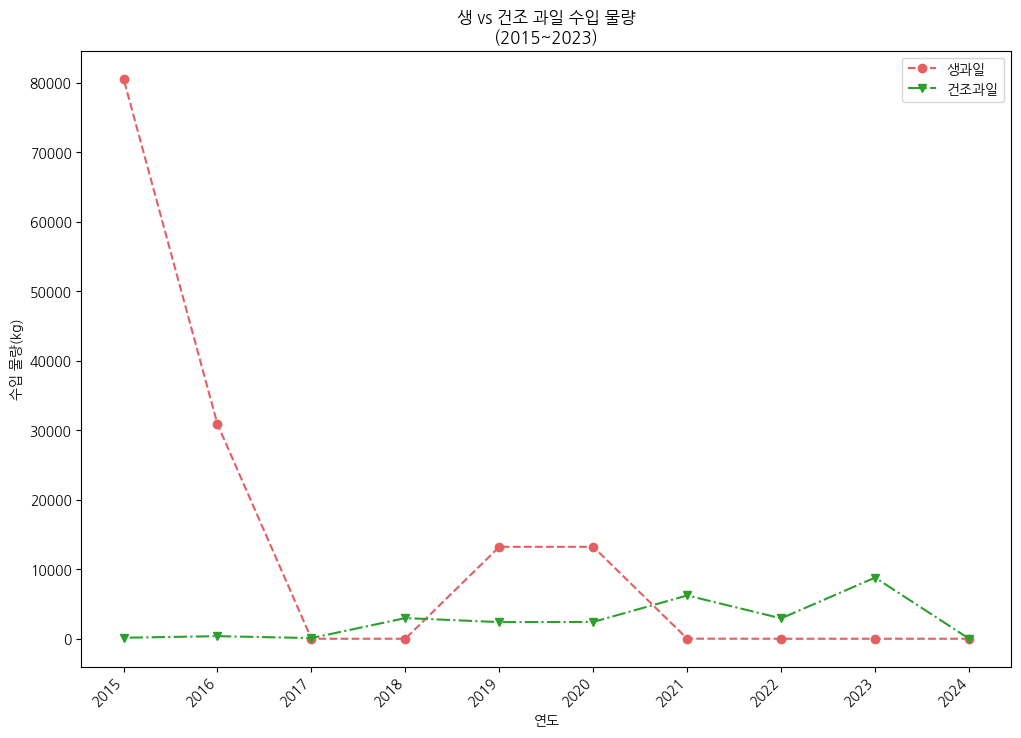

In [76]:
# 그래프의 사이즈 설정
plt.figure(figsize=(12, 8))

plt.plot(year_list[:10], raw_kg_list[:10], color='#e35f62',
         marker='o', linestyle='--', label = '생과일')

plt.plot(year_list[:10], dried_kg_list[:10], color='#2ca02c',
         marker='v', linestyle='-.', label = '건조과일')

# x축 라벨 회전
plt.xticks(rotation=45, ha='right')
# x축 간격을 1로 설정
plt.xticks(year_list[:10])

# 제목과 축 이름 설정
plt.title('생 vs 건조 과일 수입 물량\n(2015~2023)')
plt.xlabel('연도')
plt.ylabel('수입 물량(kg)')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

### 2. 생과일 vs 냉동과일 수입 물량 비교

In [53]:
original_window = Search_Item()

Original window: 64591747529B9F171C1892D7D1B5DEBA
Switched!!
New window: E0439C9C9ABC15CE39A5980CD0B8464C


#### 1. 생_초본류 딸기

In [54]:
li = ["과실·견과류", "0810", "081010", "초본류 딸기"]
New_Window(li, original_window)

Switched!!
0810100000


In [55]:
BASE_YEAR = driver.find_element(By.ID, 'BASE_YEAR')
BASE_YEAR.click()
YEARS = BASE_YEAR.find_elements(By.TAG_NAME, 'option')
#len(YEARS) 2024 ~ 2000

In [89]:
raw_berry_kg_list = Extract_item_kg(YEARS)
year_list = [y for y in range(2023,1999,-1)]

#### 2. 냉동_초본류 딸기 

In [57]:
original_window = Search_Item()

Original window: 64591747529B9F171C1892D7D1B5DEBA
Switched!!
New window: F3D1C19C1479CF705CEE73F7DABCACEC


In [58]:
li = ["과실·견과류", "0811", "081110", "초본류 딸기"]
New_Window(li, original_window)

Switched!!
0811100000


In [59]:
BASE_YEAR = driver.find_element(By.ID, 'BASE_YEAR')
BASE_YEAR.click()
YEARS = BASE_YEAR.find_elements(By.TAG_NAME, 'option')
#len(YEARS) 2024 ~ 2000

In [60]:
frozen_berry_kg_list = Extract_item_kg(YEARS)

#### DF 만들기

In [62]:
df_berry_raw_frozen = pd.DataFrame({'date': year_list, 'raw(kg)': raw_berry_kg_list, 'frozen(kg)': frozen_berry_kg_list})

df_berry_raw_frozen.drop([0], axis=0, inplace=True)
df_berry_raw_frozen = df_berry_raw_frozen.reset_index(drop=True)
df_berry_raw_frozen

,date,raw(kg),frozen(kg)
0,2023,25.22,12771256.35
1,2022,0.00,12216780.05
2,2021,0.00,9015864.58
3,2020,0.00,7887150.35
4,2019,0.00,8478942.33
5,2018,1.50,8726409.29
6,2017,0.00,8848786.09
7,2016,2.85,8792261.79
8,2015,0.00,7658783.00
9,2014,0.00,7650890.00


In [ ]:
# 그래프의 사이즈 설정
plt.figure(figsize=(20, 10))

plt.plot(year_list[:10], raw_berry_kg_list[:10], color='#e35f62',
         marker='o', linestyle='--', label = '생과일')

plt.plot(year_list[:10], frozen_berry_kg_list[:10], color='#2ca02c',
         marker='v', linestyle='-.', label = '냉동과일')

# x축 라벨 회전
plt.xticks(rotation=45, ha='right')
# x축 간격을 1로 설정
plt.xticks(year_list[:10])

# 제목과 축 이름 설정
plt.title('생 vs 냉동 과일 수입 물량\n(2015~2023)')
plt.xlabel('연도')
plt.ylabel('수입 물량(x10^7kg)')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

In [94]:
driver.close()